### Статистика по собранным данным:
- количество публикаций об упоминании университета,
- количество публикующих контент пользователей,
- количество лайков / просмотров / комментариев / репостов,
- график количество публикаций в день за собираемый период

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import psycopg2
import yaml

In [2]:
with open("config.yaml", "r", encoding="utf-8") as f:
    cfg = yaml.load(f, Loader=yaml.FullLoader)

conn = psycopg2.connect(
    host=cfg["db"]["host"],
    database=cfg["db"]["db_name"],
    user=cfg["db"]["user_name"],
    password=cfg["db"]["password"]
)
db = conn.cursor()
db.execute("SELECT post_group_id, post_id, group_id, publisher_id, date_unix, text, comments, likes, reposts, views, crawler_name FROM post\n")
posts = db.fetchall()
conn.close()

In [3]:
data = pd.DataFrame(data=posts, columns=["id", "post_id", "group_id", "publisher_id", "date_unix", "text", "comments", "likes", "reports", "views", "crawler_name"]).drop(columns=["id"])
data["date"] = data["date_unix"].apply(pd.Timestamp.fromtimestamp)

In [4]:
print("Count of post with university mention")
data["crawler_name"].value_counts()

Count of post with university mention


msu     211506
spbu     72833
Name: crawler_name, dtype: int64

In [5]:
print("Count of publishing content users per university")
(data[data["publisher_id"] > 0].groupby("crawler_name")["publisher_id"].unique().apply(len))

Count of publishing content users per university


crawler_name
msu     30338
spbu     5867
Name: publisher_id, dtype: int64

In [6]:
print("Count of likes, reposts, comments, views per university")
data.groupby("crawler_name")[["likes", "reports", "comments", "views"]].sum()

Count of likes, reposts, comments, views per university


,likes,reports,comments,views
crawler_name,,,,
msu,6035346,1583140,476244,437019738.0
spbu,1373774,545680,117276,112995320.0


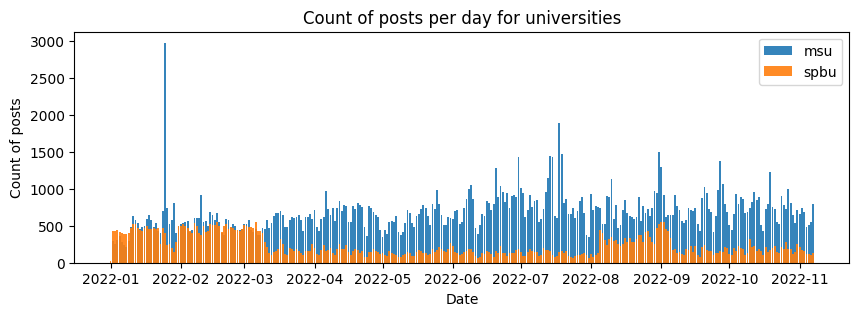

In [7]:
plt.figure(figsize=(10, 3))
for crawler_name in "msu", "spbu":
    plt.title(f"Count of posts per day for universities")
    counts = data[data["crawler_name"] == crawler_name].groupby(data["date"].apply(lambda x: x.date()))["post_id"].count()
    plt.bar(counts.index, counts.values, label=crawler_name, alpha=0.9)
    plt.xlabel("Date")
    plt.ylabel("Count of posts")
plt.legend()
plt.show()

In [8]:
data.to_csv("posts.csv", index=True)